In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import time
import os
import copy
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from ml_utils import imshow

cudnn.benchmark = True
plt.ion() # interactive mode

In [10]:
data_dir = "dataset/"

# Data preparation

To be able to feed our model with data, we basically only need to convert each picture to tensor with 3 layers, where each layer corresponds for one of the RGB channels in original picture.

Aside form that, for training data we also augment the data to decrease model variance. During data analysis, we discoovered that many images in the training set and the test/validation set are the same, therefore we aim to remove this by flipping, cropping and jittering.

We do not use these augmenting techniques on the test and validation images, as we want to get predictions on the original image, not the augmented one.

In [ ]:
data_transforms = {
    "train": transforms.Compose( [
        transforms.RandomResizedCrop( 224 ),
        transforms.RandomRotation( degrees=15 ),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] ) # pytorch expects normalization with these values n]on their models
    ] ),
    "validation": transforms.Compose( [
        transforms.Resize( 256 ),
        transforms.CenterCrop( 224 ),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] )
    ] ),
    "test": transforms.Compose( [
        transforms.Resize( size=256 ),
        transforms.CenterCrop( size=224 ),
        transforms.ToTensor(),
        transforms.Normalize( [ 0.485, 0.456, 0.406 ], [ 0.229, 0.224, 0.225 ] )
    ] ),
}

image_datasets = {
    x: datasets.ImageFolder( os.path.join( data_dir, x ), data_transforms[ x ] ) 
    for x in [ "train", "validation", "test" ]
}

dataloaders = {
    x: torch.utils.data.DataLoader( image_datasets[ x ], batch_size=4, shuffle=True, num_workers=2 )
    for x in [ "train", "validation", "test" ]
}

dataset_sizes = {
    x: len( image_datasets[ x ] )
    for x in [ "train", "validation", "test" ]
}

class_names = image_datasets[ "train" ].classes

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

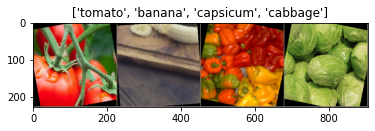

In [12]:
# Get a batch of training data
inputs, classes = next( iter( dataloaders[ "train" ] ) )

# Make a grid from batch
out = torchvision.utils.make_grid( inputs )

imshow( out, title=[ class_names[ x ] for x in classes ] )

In [13]:
def train_model( model, criterion, optimizer, scheduler, epochs=25 ):
    since = time.time()

    best_model_wts = copy.deepcopy( model.state_dict() )
    best_acc = 0

    for epoch in range( epochs ):
        print( f"Epoch { epoch + 1 }/{ epochs }" )
        print( "----------" )
        
        for phase in [ "train", "validation" ]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0

            for inputs, labels in dataloaders[ phase ]:
                inputs = inputs.to( device )
                labels = labels.to( device )

                optimizer.zero_grad()
                
                with torch.set_grad_enabled( phase == "train" ):
                    outputs = model( inputs )
                    _, preds = torch.max( outputs, 1 )
                    loss = criterion( outputs, labels )

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum( preds == labels.data )
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[ phase ]
            epoch_acc = running_corrects.double() / dataset_sizes[ phase ]

            print(f"{ phase } Loss: { epoch_loss:.4f } Acc: { epoch_acc:.4f }")

            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy( model.state_dict() )

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in { time_elapsed // 60:.0f }m { time_elapsed % 60:.0f }s")
    print(f"Best val Acc: { best_acc:4f }")

    # load the best model weights
    model.load_state_dict( best_model_wts )
    return model

In [14]:
def visualize_model( model, num_images=6 ):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate( dataloaders[ "validation" ] ):
            inputs = inputs.to( device )
            labels = labels.to( device )

            outputs = model( inputs )
            _, preds = torch.max( outputs, 1 )

            for j in range( inputs.size()[ 0 ] ):
                images_so_far += 1
                ax = plt.subplot( num_images // 2, 2, images_so_far )
                ax.axis('off')
                ax.set_title( f"predicted: { class_names[ preds[ j ] ] }" )
                imshow( inputs.cpu().data[ j ] )

                if images_so_far == num_images:
                    model.train( mode=was_training )
                    return
        
        model.train(mode=was_training)

# Model tweaking

We will use prebuilt pytorch Resnet18 model, so there is not much to tinker with, except setting optimizers and criterions. As we have here a multiclass classification problem, we use `CrossEntropyLoss` as our classifier and `SGD` for our optimizer, as we obtained a better accuracy than with `Adam`

In [15]:
model_ft = models.resnet18( pretrained=True )
num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear( num_ftrs, len( class_names ) )

model_ft.fc = nn.Sequential(
                      nn.Linear(num_ftrs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, len(class_names)),                   
                      nn.LogSoftmax(dim=1))


model_ft = model_ft.to( device )

# criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.SGD( model_ft.parameters(), lr=0.001, momentum=0.9 )
criteration = nn.NLLLoss()
optimizer_ft = optim.Adam(model_ft.parameters())

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1 )

# Model training

With this configuration, we have been able to achieve ~95% accuracy with only 25 epochs.

In [16]:
# model is already trained on our dataset, it takes ~1:30 hours to train on cpu, therefore we just load it
model = train_model(model_ft, criteration, optimizer_ft, exp_lr_scheduler)
# model = torch.load( "models/resnet.pth", map_location=torch.device( "cpu" ) ) # if gpu is not available

Epoch 1/25
----------


ValueError: Invalid format specifier

# Model evaluation

In [ ]:
visualize_model(model)
plt.ioff()
plt.show()